In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data_dir = '/kaggle/input/the-future-crop-challenge/'
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-future-crop-challenge/pr_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_train.parquet
/kaggle/input/the-future-crop-challenge/sample_submission.csv
/kaggle/input/the-future-crop-challenge/soil_co2_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_train.parquet
/kaggle/input/the-future-crop-challenge/tasmin_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_test.parquet
/kaggle/input/the-future-crop-challenge/soil_co2_maize_test.parquet
/kaggle/input/the-future-crop-challenge/train_solutions_maize.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_test.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_test.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_test.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_train.parquet
/kaggle/input/the-fu

In [2]:
#climate data (timeseries)

#soil_co2 and yields

wheat_sco2 = pd.read_parquet('/kaggle/input/the-future-crop-challenge/soil_co2_wheat_train.parquet')
wheat_yield = pd.read_parquet('/kaggle/input/the-future-crop-challenge/train_solutions_wheat.parquet')
wheat_df = wheat_sco2.join(wheat_yield)

maize_sco2 = pd.read_parquet('/kaggle/input/the-future-crop-challenge/soil_co2_maize_train.parquet')
maize_yield = pd.read_parquet('/kaggle/input/the-future-crop-challenge/train_solutions_maize.parquet')
maize_df = maize_sco2.join(maize_yield)

mean_df = pd.DataFrame()
for crop_df in [wheat_df,maize_df]:
    temp_df = crop_df.groupby(['crop','lon','lat'], as_index = False).agg({'yield':['mean','std']})
    temp_df.columns = ['crop','lon','lat','yield_mean','yield_std']
    mean_df = pd.concat([mean_df,temp_df])

mean_df


,crop,lon,lat,yield_mean,yield_std
0,wheat,-123.25,44.75,4.965216,0.488492
1,wheat,-123.25,45.25,4.985947,0.501791
2,wheat,-123.25,45.75,4.822316,0.423168
3,wheat,-122.75,44.75,4.875486,0.537611
4,wheat,-122.75,45.25,5.379421,0.615185
...,...,...,...,...,...
9298,maize,132.75,46.75,5.738692,1.191923
9299,maize,132.75,47.25,8.622872,1.518404
9300,maize,133.25,45.25,2.470256,0.359327
9301,maize,133.25,47.25,6.932128,1.339325


In [40]:
idx_lon = 132.75
idx_lat = 46.75

static_data = maize_df.query(f'lon=={idx_lon} and lat=={idx_lat}')[['co2','nitrogen','yield']]

crop = 'maize'
mode = 'train'

tasmax = pd.read_parquet(os.path.join(data_dir, f"tasmax_{crop}_{mode}.parquet")).query(f'lon=={idx_lon} and lat=={idx_lat}')
tasmin = pd.read_parquet(os.path.join(data_dir, f"tasmin_{crop}_{mode}.parquet")).query(f'lon=={idx_lon} and lat=={idx_lat}')
pr = pd.read_parquet(os.path.join(data_dir, f"pr_{crop}_{mode}.parquet")).query(f'lon=={idx_lon} and lat=={idx_lat}')
rsds = pd.read_parquet(os.path.join(data_dir, f"rsds_{crop}_{mode}.parquet")).query(f'lon=={idx_lon} and lat=={idx_lat}')

climate_data = np.stack([
        tasmax.iloc[:, 5:].values,
        tasmin.iloc[:, 5:].values,
        pr.iloc[:, 5:].values,
        rsds.iloc[:, 5:].values
    ], axis=2)

static_expanded = np.repeat(static_data.values[:,np.newaxis,:],240,axis=1)

sequenced_data = np.concatenate([climate_data,static_expanded],axis = 2)

sequenced_data.shape

(39, 240, 7)

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Data Splitting ---
inputs = sequenced_data[:, :, :-1]
targets = sequenced_data[:, -1, -1]

# --- 1. Configuration ---
n_batch = sequenced_data.shape[0] # Using full dataset as one batch
n_seq = sequenced_data.shape[1]
n_features = sequenced_data.shape[2] - 1
n_hidden = 4
n_layers = 1
learning_rate = 1e-1
n_epochs = 1000

# Regularization Hyperparameter (Adjust if needed)
HIDDEN_REG_ALPHA = 1e-4 

# Device configuration (Move all data/model to the device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"--- Configuration Summary ---")
print(f"Data Shape (Batch, Seq, Feat): ({n_batch}, {n_seq}, {n_features})")
print(f"Hidden Size/Layers: {n_hidden}/{n_layers}")
print(f"Learning Rate/Epochs: {learning_rate}/{n_epochs}")
print(f"Using Device: {device}")
print(f"-----------------------------")


# --- 2. PyTorch Dataset & DataLoader ---
class SequenceDataset(Dataset):
    def __init__(self, X, Y):
        # Move inputs to device and set dtype
        self.X = torch.from_numpy(X).to(device=device, dtype=torch.float32)
        # Move targets to device, set dtype, and unsqueeze to [batch, seq, 1] for loss calculation
        self.Y = torch.from_numpy(Y).to(device=device, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Since the DataLoader batch_size is the full dataset size, 
        # this will effectively return the entire X and Y tensors on the first call.
        return self.X[idx], self.Y[idx]

# Create DataLoader
dataset = SequenceDataset(inputs, targets)
# DataLoader batch_size is n_batch, so we get one large batch: (1, n_batch, n_seq, n_features)
dataloader = DataLoader(dataset, batch_size=n_batch, shuffle=False) 

# --- 3. Model Definition and Xavier Initialization ---

class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Using GRU as in the previous example
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
        self._init_weights()

    def _init_weights(self):
        # Xavier/Glorot Initialization
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 1)
        print("Model weights initialized with Xavier/Glorot.")

    def forward(self, x):
        # out: (batch_size, n_seq, hidden_size) - Sequence of hidden states
        out, _ = self.rnn(x)  
        
        # final_out: (batch_size, n_seq, output_size) - Final prediction
        final_out = self.fc(out)
        
        # Return both prediction and hidden states for regularization
        return final_out, out 

# Instantiate the model
model = SimpleRNNModel(
    input_size=n_features, 
    hidden_size=n_hidden, 
    num_layers=n_layers, 
    output_size=1
).to(device) # Ensure model is also on the device

# --- 4. Loss and Optimizer ---

# SmoothL1Loss for robustness
criterion_primary = nn.MSELoss().to(device) 
# AdamW Optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# --- 5. Training Loop ---

print("-" * 30)
print(f"Starting Training for {n_epochs} epochs...")
model.train() 

for epoch in range(1, n_epochs + 1):
    epoch_loss = 0
    
    for inputs_batch, targets_batch in dataloader:
        # Data is already on the device due to the Dataset implementation
        # Forward pass:
        outputs, hidden_states = model(inputs_batch)
        
        # 1. Primary Loss (Smooth L1 Loss)
        primary_loss = criterion_primary(outputs[:,-1,-1], targets_batch)

        # 2. Hidden State Regularization Loss (L2 Norm Squared)
        hidden_reg_loss = torch.norm(hidden_states, p=2)**2 * HIDDEN_REG_ALPHA
        
        # 3. Total Loss
        loss = primary_loss + hidden_reg_loss
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # Reporting every 1000 epochs to avoid excessive output
    if epoch % 100 == 0 or epoch == 1:
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch:05d}/{n_epochs}], Total Loss: {avg_loss:.6f} (Primary Loss: {primary_loss.item():.6f}, Reg Loss: {hidden_reg_loss.item():.6f})')

print("-" * 30)
print("Training Complete!")

--- Configuration Summary ---
Data Shape (Batch, Seq, Feat): (39, 240, 6)
Hidden Size/Layers: 4/1
Learning Rate/Epochs: 0.1/1000
Using Device: cpu
-----------------------------
Model weights initialized with Xavier/Glorot.
------------------------------
Starting Training for 1000 epochs...
Epoch [00001/1000], Total Loss: 26.391466 (Primary Loss: 25.951447, Reg Loss: 0.440019)
Epoch [00100/1000], Total Loss: 1.390141 (Primary Loss: 1.390141, Reg Loss: 0.000000)
Epoch [00200/1000], Total Loss: 1.390413 (Primary Loss: 1.390413, Reg Loss: 0.000000)
Epoch [00300/1000], Total Loss: 1.388135 (Primary Loss: 1.388135, Reg Loss: 0.000000)
Epoch [00400/1000], Total Loss: 1.387010 (Primary Loss: 1.387010, Reg Loss: 0.000000)
Epoch [00500/1000], Total Loss: 1.386344 (Primary Loss: 1.386344, Reg Loss: 0.000000)
Epoch [00600/1000], Total Loss: 1.385904 (Primary Loss: 1.385904, Reg Loss: 0.000000)
Epoch [00700/1000], Total Loss: 1.385594 (Primary Loss: 1.385594, Reg Loss: 0.000000)
Epoch [00800/1000],

In [44]:
#Problem: the model learns to simply output the mean:

print(f'prediction:{outputs[:,-1,-1].T} \n target: {targets_batch.T}',)

prediction:tensor([5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105,
        5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105,
        5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105,
        5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105, 5.7105,
        5.7105, 5.7105, 5.7105], grad_fn=<PermuteBackward0>) 
 target: tensor([5.7080, 9.0650, 7.3420, 7.2810, 6.6670, 7.2130, 5.0140, 7.0010, 7.2100,
        7.1030, 4.3850, 5.4710, 5.1450, 3.9540, 5.3020, 4.1590, 7.0940, 6.8150,
        4.9010, 5.3520, 5.2200, 4.9870, 3.9630, 5.7780, 5.7900, 4.3860, 4.7540,
        6.3600, 5.2410, 4.6310, 5.2920, 6.5230, 3.9460, 6.3060, 4.8780, 7.0870,
        5.4730, 4.7720, 6.2400])


## Learning a time-series -> yield function

Here we're very data-limited using only a single location. There are 240x4+1 inputs, but only 39 training examples. 

1. DNN with dropout (for generalisation). With a VAE-like dimension reduction layer-by-layer.

One idea would be to do a convolution over the 240x4 inputs and reduce them to an N dimensional signal, which is then combined with the C02 data to produce a yield estimate. This might not be crazy at all.



In [59]:
# DNN with dropout
# simply map continous data onto the yield with an N-deep network trained with dropout.

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- 2. PyTorch Dataset & DataLoader (Updated for 1D target) ---
class FlattenedDataset(Dataset):
    def __init__(self, climate_data, soil_co2, crop_yield, datatype=torch.float32):
        """Takes numpy arrays as inputs.
        climate_data shaped as (n_batch, n_seq, n_features)
        soil_co2 and crop_yield both 1d arrays"""
        N, S, F = climate_data.shape
        # X: Flattened to [N, S * F]
        self.X = torch.from_numpy(climate_data).reshape(N, S * F)
        self.X = torch.concat([self.X,torch.from_numpy(soil_co2).unsqueeze(-1)],axis=1).to(device, dtype=datatype)
        # Y: Unsqueeze to [N, 1] for consistent loss calculation
        self.Y = torch.from_numpy(crop_yield).unsqueeze(-1).to(device=device, dtype=datatype)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# --- 3. Flexible Model Definition and Xavier Initialization (DNN) ---

class FlexibleFlattenedDNN(nn.Module):
    def __init__(self, input_size, output_size, num_layers, reduction_ratio, dropout_rate=0.0, leaky_relu_slope=0.01):
        super(FlexibleFlattenedDNN, self).__init__()
        self.leaky_relu_slope = leaky_relu_slope
        layers = []
        current_size = input_size
        
        # Dynamically build the hidden layers
        for i in range(num_layers):
            # Calculate the size of the next layer
            next_size = max(4, int(current_size * reduction_ratio)) # Min size of 4 for stability
            
            # Add Linear Layer
            layers.append(nn.Linear(current_size, next_size))
            # Add Activation
            layers.append(nn.LeakyReLU(self.leaky_relu_slope)) #similar results with ReLU and leakyReLU, the latter being more stable.
            
            # Add Dropout (only for intermediate layers)
            if dropout_rate > 0 and i < num_layers - 1:
                 layers.append(nn.Dropout(dropout_rate)) 
                
            current_size = next_size
        
        # Add the final output layer (no activation or dropout after this)
        layers.append(nn.Linear(current_size, output_size))
        
        self.fc_stack = nn.Sequential(*layers)
        
        print(f"DNN Architecture built: {input_size} -> {[l.out_features for l in layers if isinstance(l, nn.Linear)]}")
        
        self._init_weights()

    def _init_weights(self):
        # Xavier/Glorot Initialization for all Linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                #nn.init.xavier_uniform_(m.weight)
                nn.init.kaiming_uniform_(m.weight, a = self.leaky_relu_slope)
                #if m.bias is not None:
                #    nn.init.constant_(m.bias, 0)
        print("Model weights initialized with Kaiming/He (leaky relu).")

    def forward(self, x):
        return self.fc_stack(x) 

# --- 1. Configuration ---
n_batch = sequenced_data.shape[0] 
n_seq = sequenced_data.shape[1]   
n_features = sequenced_data.shape[2] - 1

# --- MODEL FLEXIBILITY PARAMETERS ---
NUM_HIDDEN_LAYERS = 3    # The number of layers between input and output (e.g., 3 for 4 layers total)
REDUCTION_RATIO = 1/6      # The ratio by which each layer size decreases (e.g., 0.5 means half the size)
DROPOUT_RATE = 2/5        # Dropout rate for intermediate layers (0.0 for no dropout)

# --- CALCULATED DIMENSIONS ---
FLATTENED_INPUT_SIZE = n_seq * 4+1 
TARGET_OUTPUT_SIZE = 1 # Corrected to 1D output

# Hyperparameter
init_LR = 3e-9 #initial learning rate with AdamW
max_LR = 9e-3 #max learning rate with 
weight_decay = 1e-5 #must be small with 'super-convergence'
n_epochs = 5000


# Create DataLoader
dataset = FlattenedDataset(climate_data, static_data.co2.values,static_data['yield'].values,
                          datatype = torch.float64)
dataset
n_train = int(dataset.X.shape[0]*0.8)
n_test = dataset.X.shape[0]-n_train

train_dataset = torch.utils.data.Subset(dataset, range(n_train))
val_dataset = torch.utils.data.Subset(dataset,range(n_train,n_train+n_test))

train_loader = DataLoader(train_dataset, batch_size=n_batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = n_batch, shuffle = False)

# Instantiate the flexible model
model = FlexibleFlattenedDNN(
    input_size=FLATTENED_INPUT_SIZE,
    output_size=TARGET_OUTPUT_SIZE,
    num_layers=NUM_HIDDEN_LAYERS,
    reduction_ratio=REDUCTION_RATIO,
    dropout_rate=DROPOUT_RATE
).to(device, dtype=torch.float64)

n_params = sum([p.numel() for p in model.parameters()])
print(f"Model instantiatied with {n_params} parameters.")
# --- 4. Loss and Optimizer ---

# Switched back to MSELoss as requested in the original code block
criterion_primary = nn.MSELoss().to(device) 
optimizer = optim.AdamW(model.parameters(), lr=init_LR, weight_decay = weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_LR, 
                                          steps_per_epoch=1, 
                                          epochs=n_epochs)

# --- 5. Training Loop (Unchanged) ---

print("-" * 30)
print(f"Starting Training for {n_epochs} epochs...")
model.train() 

for epoch in range(1, n_epochs + 1):
    for inputs_batch, targets_batch in train_loader:
        # Backward and optimize
        optimizer.zero_grad()
        
        # Forward pass:
        outputs = model(inputs_batch)
        
        # Calculate loss (outputs: [N, 1], targets: [N, 1])
        loss = criterion_primary(outputs, targets_batch)
        
        
        loss.backward()
        optimizer.step()
        scheduler.step()

    if epoch % 1000 == 0 or epoch == 1:
        avg_loss = loss 
        print(f'Epoch [{epoch:05d}/{n_epochs}], Loss: {avg_loss:.6f}')
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_inputs, val_targets in val_loader:
                val_preds = model(val_inputs)
                val_losses.append(criterion_primary(val_preds,val_targets).item())

        print(f'Validation loss: {np.mean(val_losses):.6f}')
print("-" * 30)
print("Training Complete!")

DNN Architecture built: 961 -> [160, 26, 4, 1]
Model weights initialized with Kaiming/He (leaky relu).
Model instantiatied with 158219 parameters.
------------------------------
Starting Training for 5000 epochs...
Epoch [00001/5000], Loss: 67338.892383
Validation loss: 15978.741765
Epoch [01000/5000], Loss: 0.080852
Validation loss: 1.208271
Epoch [02000/5000], Loss: 0.000000
Validation loss: 1.211101
Epoch [03000/5000], Loss: 0.000000
Validation loss: 1.210991
Epoch [04000/5000], Loss: 0.000000
Validation loss: 1.210916
Epoch [05000/5000], Loss: 0.000000
Validation loss: 1.210904
------------------------------
Training Complete!


tensor([[6.9018, 5.3536, 6.1327, 6.4250, 6.1035, 6.0752, 5.3952, 6.1213]],
       dtype=torch.float64) 
 tensor([[6.5230, 3.9460, 6.3060, 4.8780, 7.0870, 5.4730, 4.7720, 6.2400]],
       dtype=torch.float64)


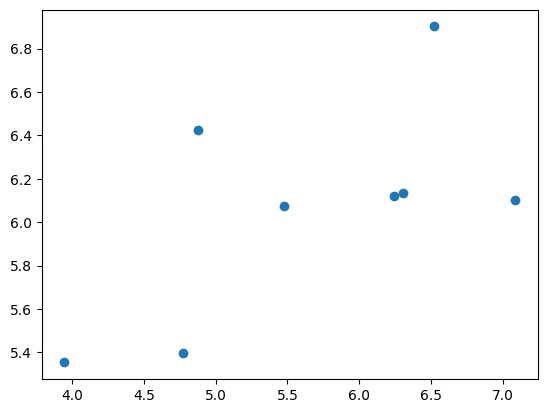

In [56]:
#Are we outputting a constant prediction (mean), or are we trying to generalise some pattern?

print(val_preds.T, '\n',val_targets.T)
import matplotlib.pyplot as plt
plt.scatter(x=val_targets.numpy(), y=val_preds.numpy())

In [36]:
for name, params in model.named_parameters():
    print(name)

model.fc_stack[(0)].weight # the weight associated with co2 has negative inputs on the unit activations! 
#i.e. the model is is roughly capturing a negative correlation with soil c02 and yield.

fc_stack.0.weight
fc_stack.0.bias
fc_stack.3.weight
fc_stack.3.bias
fc_stack.6.weight
fc_stack.6.bias
fc_stack.8.weight
fc_stack.8.bias


Parameter containing:
tensor([[ 0.0406, -0.0559,  0.0586,  ..., -0.0239,  0.0168,  0.0134],
        [ 0.0504,  0.0145, -0.0682,  ..., -0.0330, -0.0478,  0.0058],
        [ 0.0448, -0.0062,  0.0723,  ...,  0.0038, -0.0442, -0.0288],
        ...,
        [ 0.0063,  0.0200,  0.0574,  ..., -0.0422, -0.0479, -0.0270],
        [ 0.0446,  0.0139,  0.0368,  ..., -0.0446, -0.0054, -0.0102],
        [-0.0121, -0.0512, -0.0214,  ..., -0.0095, -0.0316, -0.0132]],
       dtype=torch.float64, requires_grad=True)

In [37]:
print(val_preds.T, '\n',val_targets.T)

tensor([[8.6381, 7.5271, 8.3603, 7.7943, 9.4586, 9.5836, 8.2634, 8.4436]],
       dtype=torch.float64) 
 tensor([[ 9.5290,  7.0030,  8.6340,  7.4670, 11.5860,  8.8950,  7.3440,  8.9260]],
       dtype=torch.float64)
